# CIROH Developers Conference: Hydrological Applications of ML
### CNNs for Predicting Daily Orographic Precipitation Gradients (OPGs) for Atmospheric Downscaling

## Introduction to Facets and OPGs:

 A good place to start is familiarizing ourselves with the datasets we'll use in this workshop. We'll start with facets, precipitation, and OPGs in Northern Utah. Our formulated orographic precipitation gradients are from a climatology of the western United States created by [Bohne et al. (2020)](https://doi.org/10.1175/JHM-D-19-0229.1).

- Facets are topographic regions in complex terrain defined by the same facing orientation based on a 15-rule algorithm by [Gibson et al. (1997)](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=07e4be8943e54e3113b2dc4f4949d295ced28dee).

- Precipitation observations were taken from the Global Historical Climatology Network-Daily data (GHCND).

- OPGs (Orographic Precipitation Gradients) are the linear relationship between daily precipitation and elevation at each facet.

##### Lets start by importing the necessary Python libraries.

In [1]:
# Global imports
# Here, Pandas will be used to load in csv datasets
import pandas as pd 
import numpy as np 
# Atmospheric data are often put in NetCDF data 
# files, which are best opened using Xarray
import xarray as xr 

# Libraries for plotting data
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from datetime import datetime

# You can also load in other python scripts that contain 
# functions like a Python Library. This one contains a list 
# of Colormaps for plotting
import nclcmaps as ncm

##### Next, lets load in the topographic elevations, labeled facets, facet orientations, latitudes, longitudes, and OPGs.

In [2]:
# Path to facet and opg datasets
path = "../datasets/facets_and_opgs/"

# Load in topographic and OPG data
elev        = np.array(pd.read_csv(f"{path}elevation.csv", index_col=0))
facets      = np.array(pd.read_csv(f"{path}facet_labels.csv", index_col=0))
lats        = np.array(pd.read_csv(f"{path}lats.csv", index_col=0))
lons        = np.array(pd.read_csv(f"{path}lons.csv", index_col=0))
orientation = np.array(pd.read_csv(f"{path}facet_orientation.csv", index_col=0))
opg         = pd.read_csv(f"{path}winter_northernUT_opg.csv", index_col=0)

##### Below, we'll plot the region of study for this workshop, Northern Utah, and the facets we'll be predicting OPGs for.

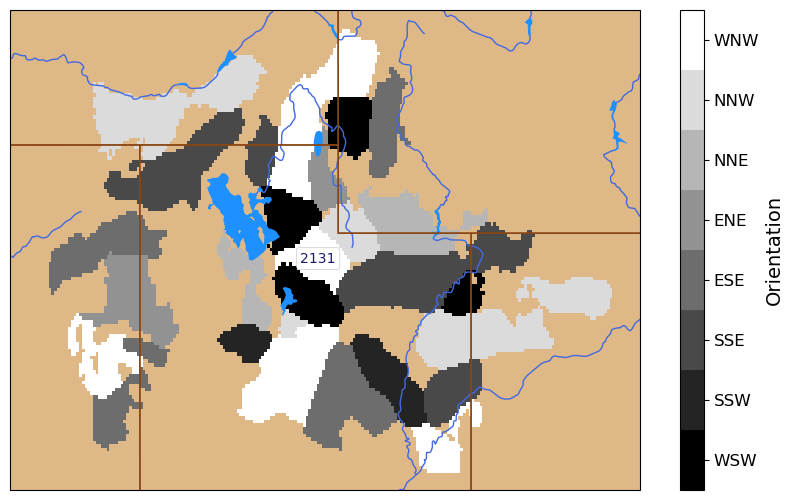

In [3]:
# Define a custom colormap
cmap_fi = ListedColormap([[0.0, 0.0, 0.0],[0.1428, 0.1428, 0.1428],[0.2857, 0.2857, 0.2857],
           [0.4285, 0.4285, 0.4285],[0.5714, 0.5714, 0.5714],[0.7142, 0.7142, 0.7142],
           [0.8571, 0.8571, 0.8571],[1.0, 1.0, 1.0]])

# Set flat facets to nan to remove from plot
orientx = orientation.astype('float')
orientx[orientx == 9] = np.nan 

# Preset Variables
extent  = [-116, -106.5, 38, 43.5] # extent of plotting window in lons then lats
datacrs = ccrs.PlateCarree()

# Create Figure
fig = plt.figure( figsize = (10, 6))
ax  = fig.add_axes( [0.1, 0.1, 0.8, 0.8], projection = ccrs.Mercator(central_longitude=np.mean(lons)) )

# Plot Facets and Shade Them Based On Their Orientation
pcm = ax.pcolormesh(lons, lats, orientx, cmap=cmap_fi, transform=datacrs, shading='auto')
pcm.set_clim(0.5,8.5)

# Add label on facet 2131
plt.text(np.median(lons[facets==2131]), np.median(lats[facets==2131]), str(2131), fontsize = 10, color = 'midnightblue', 
              transform = datacrs, ha = 'center', va = 'center', bbox=dict(boxstyle="round", fc=(1,1,1), linewidth=0.1))

# Cartography Features
ax.add_feature(cfeat.LAND, facecolor="burlywood")
ax.add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor="royalblue")
ax.add_feature(cfeat.LAKES.with_scale('10m'), facecolor="dodgerblue")
ax.add_feature(cfeat.STATES.with_scale('10m'), edgecolor="saddlebrown")
ax.set_extent(extent)

# Add colorbar
cbar = plt.colorbar(pcm, ticks=[0,1,2,3,4,5,6,7,8,9])
cbar.set_label("Orientation", fontsize=14)
cbar.ax.set_yticklabels(['','WSW','SSW','SSE','ESE','ENE','NNE','NNW','WNW',''])
cbar.ax.tick_params(labelsize=12)

# Save and Show Figure
path = "../figures/"
plt.savefig(f"{path}facet_orientations.png", dpi=200, transparent=True,  bbox_inches='tight')
plt.show()

##### Each of the above regions shaded from white to black are a facet. Facets are defined as regions with the same general facing orientation, determined using the [Gibson et al. (1997)](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=07e4be8943e54e3113b2dc4f4949d295ced28dee) algorithm which evaluates the facing orientation of each gird point accounting for the orientation of its surrounding gridpoints. 

##### The total number of facets in our dataset is 30, but lets take a closer look at the observed OPGs found on facet 2131, which is labeled above.

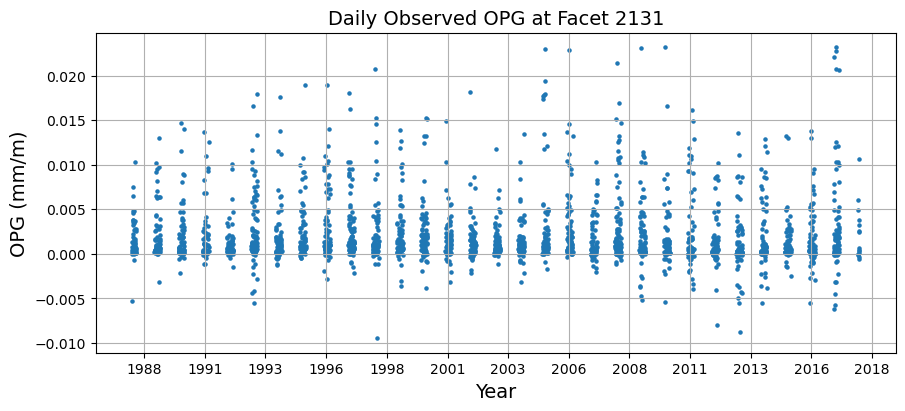

In [4]:
# reformat dates for plotting
xdata = opg.index
xdata = [datetime.strptime(x, '%Y-%m-%d') for x in xdata]

# Create figure
fig = plt.figure( figsize = (10, 4))
ax  = fig.add_axes( [0.1, 0.1, 0.8, 0.8])

# Plot OPGs as scatter plots
plt.scatter(xdata, opg["2131"], s=5)

# Set labels
plt.xlabel("Year", fontsize=14)
plt.ylabel("OPG (mm/m)", fontsize=14)
plt.title("Daily Observed OPG at Facet 2131", fontsize=14)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)

# Save and Show Figure
path = "../figures/"
plt.savefig(f"{path}opg_timeseries_facet2131.png", dpi=200, transparent=True,  bbox_inches='tight')
plt.show()

##### The above plot shows a timeseries of observed OPGs on facet 2131 for only the winter months. Like most facets in this region, OPGs tend to be positive, meaning, precipitation tends to increase with elevation. 

## ECMWF ERA5:
##### In the next script we will create a Convolutional Neural Network (CNN) to predict the OPGs on the above facets. To predict OPGs, we'll use the listed daily atmospheric variables formulated from the ECMWF's ERA5 dataset:
- IVT
- Accumulated precipitation
- 700 hPa temperatures
- 700 hPa U-Winds
- 700 hPa V-Winds
- 500 hPa geopotential heights

##### To get an understanding of these variables, lets plot a few days of data.

In [5]:
# Set path to ERA5 data
path = "../datasets/era5_atmos/"

# Load in atmospheric data
IVT       = xr.open_dataset(f"{path}IVT_sfc.nc")
precip    = xr.open_dataset(f"{path}precip_sfc.nc")*1000
temp700   = xr.open_dataset(f"{path}temp_700.nc")-273.15
uwinds700 = xr.open_dataset(f"{path}uwnd_700.nc")
vwinds700 = xr.open_dataset(f"{path}vwnd_700.nc")
hgt500    = xr.open_dataset(f"{path}hgt_500.nc")/9.81

##### The atmospheric data are in NetCDF files. This file type is used because it includes information about the dataset it contains. Below, lets print what is inside of the precip file.

In [6]:
print(precip)

<xarray.Dataset>
Dimensions:    (latitude: 19, longitude: 27, time: 2708)
Coordinates:
  * latitude   (latitude) float32 36.0 36.5 37.0 37.5 ... 43.5 44.0 44.5 45.0
  * longitude  (longitude) float32 -119.0 -118.5 -118.0 ... -107.0 -106.5 -106.0
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 2017-12-31
Data variables:
    precip     (time, latitude, longitude) float32 0.02396 0.0 ... 0.09616


##### Above we first see the `Dimensions` of the dataset: Latitude, Longitude, and time. These dimension variables are listed under `Coordinates`, which allows us to easily work with the precip data. Then `Data variables` lists precip. A NetCDF file has the ability to list numerous `Data variables` of any combination of the above `Coordinates`.

In [7]:
# Subset to a week of observations
dates = ['2017-01-07', '2017-01-12']

IVT       = IVT.sel(time=slice(dates[0], dates[1]))
precip    = precip.sel(time=slice(dates[0], dates[1]))
temp700   = temp700.sel(time=slice(dates[0], dates[1]))
uwinds700 = uwinds700.sel(time=slice(dates[0], dates[1]))
vwinds700 = vwinds700.sel(time=slice(dates[0], dates[1]))
hgt500    = hgt500.sel(time=slice(dates[0], dates[1]))

##### With an Xarray dataset, the coordinates can be used to subset the Data variables. Above, we selected atmosheric data sliced between two datetimes.

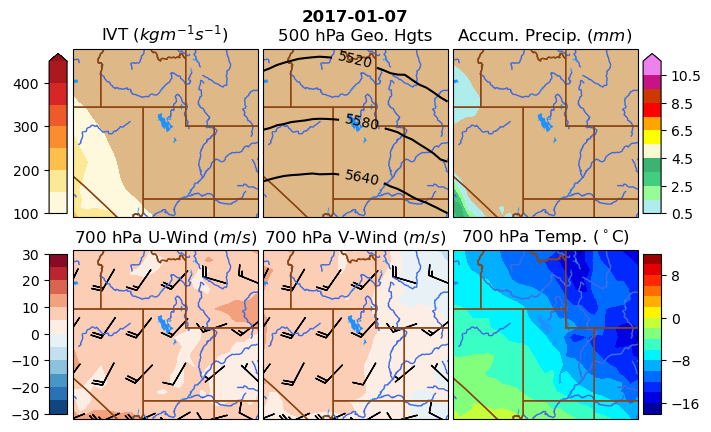

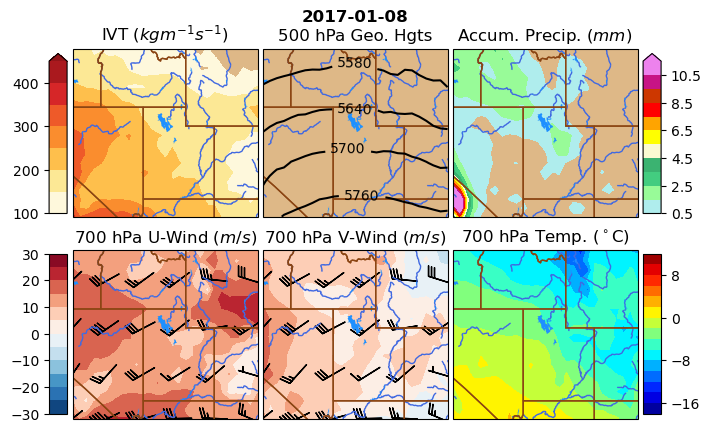

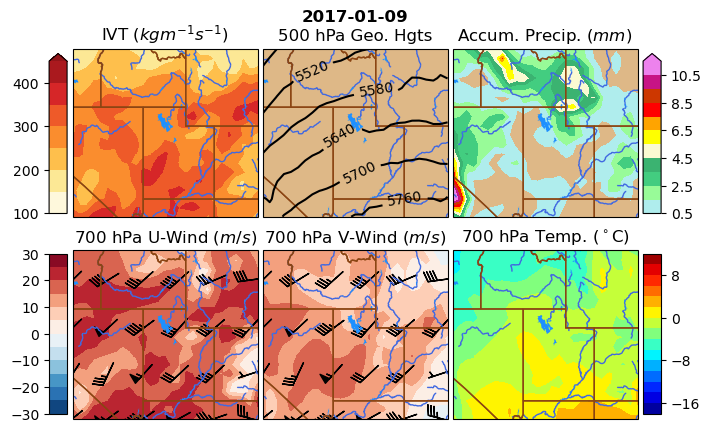

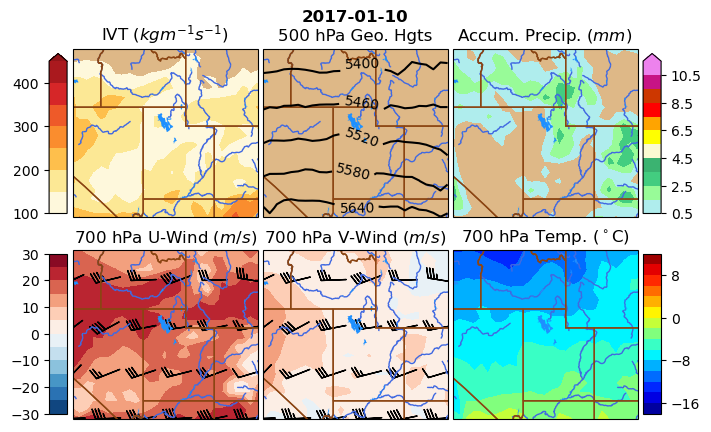

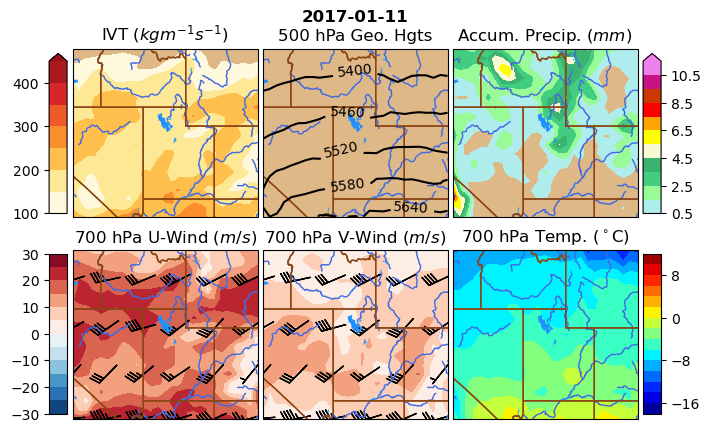

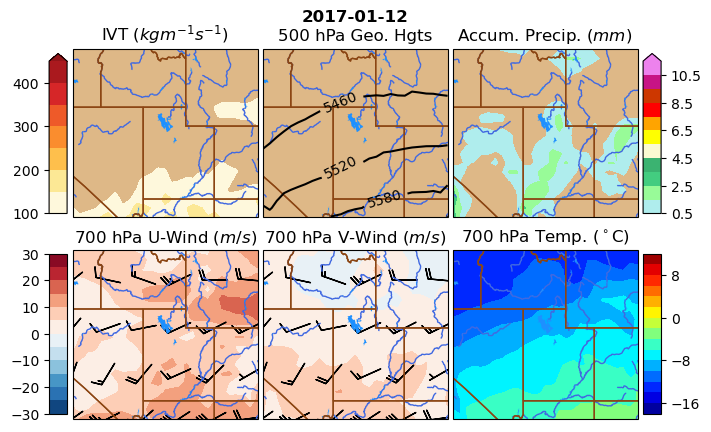

In [8]:
# plotting

# Plot Transforms
datacrs = ccrs.PlateCarree()
projex  = ccrs.Mercator(central_longitude=np.mean(lons))
extent  = [-119, -106, 36, 45]

# Loop through each day
for dayx in range(len(IVT.time.values)):
    
    # Create figure
    fig, axs = plt.subplots(2, 3, figsize = (6, 4), subplot_kw={'projection': projex})
    fig.tight_layout()
    
    # Plot contourf and contour plots
    ivt_cbar = axs[0, 0].contourf(IVT.longitude, IVT.latitude, IVT.IVT.values[dayx,:,:], cmap=ncm.cmap('WhiteYellowOrangeRed'), 
                                  levels=np.arange(100, 500, 50), extend='max', transform=datacrs)
    cs       = axs[0, 1].contour(hgt500.longitude, hgt500.latitude, hgt500.hgt.values[dayx,:,:], colors='black', 
                                 levels=np.arange(5160, 5880, 60), transform=datacrs)
    pr_cbar  = axs[0, 2].contourf(precip.longitude, precip.latitude, precip.precip.values[dayx,:,:], 
                                  cmap=ncm.cmapDiscrete('prcp_2', indexList=np.arange(1,12)), levels=np.arange(0.5, 12, 0.5), 
                                  extend='max', transform=datacrs)
    u_cbar   = axs[1, 0].contourf(uwinds700.longitude, uwinds700.latitude, uwinds700.uwnd.values[dayx,:,:], 
                                  cmap=ncm.cmap('MPL_RdBu', True), levels=np.arange(-30, 30+1, 5), transform=datacrs)
    v_cbar   = axs[1, 1].contourf(vwinds700.longitude, vwinds700.latitude, vwinds700.vwnd.values[dayx,:,:], 
                                  cmap=ncm.cmap('MPL_RdBu', True), levels=np.arange(-30, 30+1, 5), transform=datacrs)
    tmp_cbar = axs[1, 2].contourf(temp700.longitude, temp700.latitude, temp700.temp.values[dayx,:,:], 
                                  cmap=ncm.cmap('NCV_jet'), levels=np.arange(-18, 12+2, 2), transform=datacrs)

    # Add wind barbs
    u700 = uwinds700.uwnd.values[dayx,::5,::5] * 1.94384  
    v700 = vwinds700.vwnd.values[dayx,::5,::5] * 1.94384
    axs[1, 0].barbs(uwinds700.longitude[::5], uwinds700.latitude[::5], u700, v700, length=6, pivot='middle', transform=datacrs)
    axs[1, 1].barbs(uwinds700.longitude[::5], uwinds700.latitude[::5], u700, v700, length=6, pivot='middle', transform=datacrs)
    
    # Set titles
    axs[0, 0].set_title("IVT ($kg m^{-1} s^{-1}$)")  
    axs[0, 1].set_title("500 hPa Geo. Hgts")
    axs[0, 2].set_title("Accum. Precip. ($mm$)")
    axs[1, 0].set_title("700 hPa U-Wind ($m/s$)")
    axs[1, 1].set_title("700 hPa V-Wind ($m/s$)")
    axs[1, 2].set_title("700 hPa Temp. ($^\circ$C)")

    # Plot 500 hPa geopotential height contour labels
    axs[0, 1].clabel(cs, fmt="%d", inline = True)
    
    # Add Cartogrphy
    for row in range(2):
        for col in range(3):
            axs[row,col].add_feature(cfeat.LAND, facecolor="burlywood")
            axs[row,col].add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor="royalblue")
            axs[row,col].add_feature(cfeat.LAKES.with_scale('10m'), facecolor="dodgerblue")
            axs[row,col].add_feature(cfeat.STATES.with_scale('10m'), edgecolor="saddlebrown")
            axs[row,col].set_extent(extent)

    # Add colorbars
    cx_ivt = fig.add_axes([-0.01, 0.55, 0.03, 0.40])
    fig.colorbar(ivt_cbar, cax=cx_ivt, ticks=np.arange(100, 500, 100), orientation='vertical', location='left')

    cx_u = fig.add_axes([-0.01, 0.05, 0.03, 0.40])
    fig.colorbar(u_cbar, cax=cx_u, ticks=np.arange(-30, 30+1, 10), orientation='vertical', location='left')

    cx_tmp = fig.add_axes([0.98, 0.05, 0.03, 0.40])
    fig.colorbar(tmp_cbar, cax=cx_tmp, ticks=np.arange(-24, 24, 8), orientation='vertical', location='right')

    cx_pr = fig.add_axes([0.98, 0.55, 0.03, 0.40])
    fig.colorbar(pr_cbar, cax=cx_pr, ticks=np.arange(0.5, 12, 2), orientation='vertical', location='right')

    # adjust plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    datex = np.datetime_as_string(IVT.time.values[dayx], unit="D")
    plt.suptitle(datex, y=1.06, weight='bold')

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}atmos_{datex}.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()



##### The above plots display the 6 predictor variables we will use today to predict OPGs in Northern Utah. These variables are highly correlated with precipitation events. IVT (integrated vapor transport) is the volumetric amount of water transported, accumulated precipitation tends to have the strongest correlation to OPG, 700 hPa temperature, U-winds, V-winds, and 500 hPa geopotential heights are used to evaluate the large scale structure of the atmosphere.
